Based on [Generating Abstract Patterns with TensorFlow](http://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/) by Otoro

In [347]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
plt.style.use('ggplot')

In [348]:
# "Library" code
# Cribbed from https://github.com/dribnet/plat/blob/master/plat/interpolate.py
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

# Cribbed from https://github.com/pkmital/CADL/blob/master/session-5/libs/gif.py
# Copyright Parag Mital
def build_gif(imgs, interval=0.1, dpi=72,
              save_gif=True, saveto='animation.gif',
              show_gif=False, cmap=None):
    """Take an array or list of images and create a GIF.
    Parameters
    ----------
    imgs : np.ndarray or list
        List of images to create a GIF of
    interval : float, optional
        Spacing in seconds between successive images.
    dpi : int, optional
        Dots per inch.
    save_gif : bool, optional
        Whether or not to save the GIF.
    saveto : str, optional
        Filename of GIF to save.
    show_gif : bool, optional
        Whether or not to render the GIF using plt.
    cmap : None, optional
        Optional colormap to apply to the images.
    Returns
    -------
    ani : matplotlib.animation.ArtistAnimation
        The artist animation from matplotlib.  Likely not useful.
    """
    imgs = np.asarray(imgs)
    h, w, *c = imgs[0].shape
    fig, ax = plt.subplots(figsize=(np.round(w / dpi), np.round(h / dpi)))
    fig.subplots_adjust(bottom=0)
    fig.subplots_adjust(top=1)
    fig.subplots_adjust(right=1)
    fig.subplots_adjust(left=0)
    ax.set_axis_off()

    if cmap is not None:
        axs = list(map(lambda x: [
            ax.imshow(x, cmap=cmap)], imgs))
    else:
        axs = list(map(lambda x: [
            ax.imshow(x)], imgs))

    ani = animation.ArtistAnimation(
        fig, axs, interval=interval*1000, repeat_delay=0, blit=True)

    if save_gif:
        ani.save(saveto, writer='imagemagick', dpi=dpi)

    if show_gif:
        plt.show()
    else:
        plt.close(fig)

    return ani


In [354]:
def coordinates(x_dim, y_dim, scale=1.0, batch_size=1):
    with tf.variable_scope('coordinates'):
        xs = scale * tf.linspace(-1.0, 1.0, x_dim)
        ys = scale * tf.linspace(-1.0, 1.0, y_dim)
        xv, yv = tf.meshgrid(xs, ys)
        xv = tf.reshape(xv, [1, -1, 1])
        yv = tf.reshape(yv, [1, -1, 1])
        rv = tf.reshape(tf.sqrt(xv ** 2 + yv ** 2), [1, -1, 1])
        return (tf.tile(xv, [batch_size, 1, 1]), 
                tf.tile(yv, [batch_size, 1, 1]),
                tf.tile(rv, [batch_size, 1, 1]))

def dense(inputs, units, use_bias=True, activation=None):
    return tf.layers.dense(inputs=inputs, units=units, 
                           kernel_initializer=tf.random_normal_initializer(stddev=1.0), 
                           bias_initializer=tf.random_normal_initializer(stddev=1.0),
                           use_bias=use_bias,
                           activation=activation)

def cppn_model_fn(x_dim, y_dim, c_dim, z_dim, hidden_units, scale=1.0):
    tf.reset_default_graph()
    with tf.variable_scope('cppn'):
        input = tf.placeholder(tf.float32, shape=[None, z_dim])
        batch_size = tf.shape(input)[0]
        xs, ys, rs = coordinates(x_dim, y_dim, scale, batch_size)
        zs = tf.tile(input[:, tf.newaxis, :], [1, x_dim * y_dim, 1])
        H = tf.nn.tanh(dense(xs, hidden_units[0], use_bias=False, activation=None) + 
                       dense(ys, hidden_units[0], use_bias=False, activation=None) +
                       dense(rs, hidden_units[0], use_bias=False, activation=None) + 
                       dense(zs, hidden_units[0], activation=None))
        for units in hidden_units[1:]:
            H = dense(H, units, activation=tf.nn.tanh)
        output = dense(H, c_dim, activation=tf.nn.sigmoid)
        output = tf.reshape(output, [batch_size, y_dim, x_dim, c_dim])
        return {
            'batch_size': batch_size,
            'input': input,
            'output': output,
            'params': {
                'x_dim': x_dim,
                'y_dim': y_dim,
                'c_dim': c_dim,
                'z_dim': z_dim,
                'scale': scale,
                'hidden_units': hidden_units
            }
        }

def generate(model, zs):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        return sess.run(model['output'], feed_dict={model['input']: zs})
    
def generate_batch(model, batch_size=1):
    zs = model['params']['scale'] * np.random.uniform(
        -1.0, 1.0, size=[batch_size, model['params']['z_dim']])
    return zs, generate(model, zs)

def generate_slerp(model, steps=100):
    zs = model['params']['scale'] * np.random.uniform(
        -1.0, 1.0, size=[steps, model['params']['z_dim']])
    start_z = zs[0]
    end_z = zs[-1]
    for i in range(1, steps - 1):
        idx = float(i) / steps
        zs[i, :] = slerp(idx, start_z, end_z)
    return zs, generate(model, zs)

In [358]:
x_dim = 1080
y_dim = 720
c_dim = 3
z_dim = 8
scale = 16.0
batch_size = 1
num_hidden_units = [32, 32, 32]
output = cppn_model_fn(x_dim, y_dim, c_dim, z_dim, num_hidden_units, scale)

In [365]:
zs, images = generate_batch(output, batch_size)
print(images.shape)

(1, 720, 1080, 3)


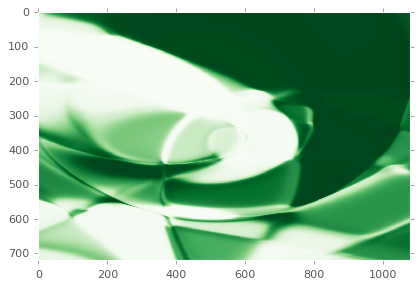

In [390]:
plt.grid()
plt.imshow(images[0][:, :, 0], cmap='Greens', interpolation='nearest')

(30, 720, 1080, 3)


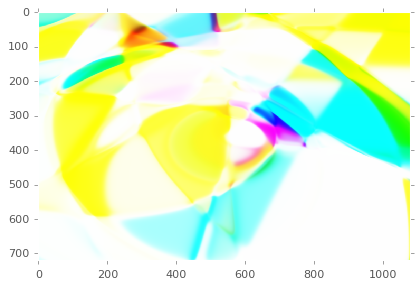

In [393]:
zs, images = generate_slerp(output, 30)
print(images.shape)
plt.grid()
plt.imshow(images[0], cmap='Greens', interpolation='nearest')

In [397]:
build_gif(images[:, :, :, 0], interval=.1, cmap='Greens', save_gif=True, saveto='cppn_greens.gif')